In [2]:
from typing import List, Optional, Literal, Iterator

import numpy as np
import pandas as pd

from sklearn.metrics import brier_score_loss

from tqdm import tqdm

import os

In [3]:
x_train = pd.read_csv('data/x_train.txt', sep='\s+', header=None)
y_train = pd.read_csv('data/y_train.txt', header=None)[0]
x_test = pd.read_csv('data/x_train.txt', sep='\s+', header=None)

In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 500 entries, 0 to 499
dtypes: float64(500)
memory usage: 19.1 MB


In [5]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: 0
Non-Null Count  Dtype
--------------  -----
5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


In [6]:
y_train.value_counts()

0 2504
1 2496
Name: 0, dtype: int64

In [7]:
x_test.shape

(5000, 500)

# Functions related to customer selection

In [8]:
def select_customers(y_pred_proba, n_customers=1000) -> List[int]:
    """
    Selects n customers that are most likely to use the offer
    """
    customers_preds = pd.DataFrame({
        'customer_id': np.arange(len(y_pred_proba)),
        'pred': y_pred_proba[:, 1],
    })
    customers_preds = customers_preds.sort_values('pred', ascending=False)
    selected_customers = customers_preds.iloc[:n_customers, 0].tolist()
    return selected_customers

In [9]:
def save_solution(y_pred_proba_test, variables_used: List[int]) -> None:
    """
    Save selected customers to a file like specified in the task description
    """    
    selected_customers = select_customers(y_pred_proba_test, n_customers=1000)
        
    first_student_id = '313467'
            
    # save customers
    with open(f'{first_student_id}_obs.txt', 'w') as file:
        for customer_id in selected_customers:
            file.write(f'{customer_id + 1}\n')

    # save variables
    with open(f'{first_student_id}_vars.txt', 'w') as file:
        for var_name in variables_used:
            file.write(f'{var_name + 1}\n')

In [10]:
def calculate_score(y_true, y_pred_proba, n_vars_used: int, n_customers=1000) -> int:
    """
    Calculates score in € as specified in the task description.
    """
    selected = select_customers(y_pred_proba, n_customers)
    true_for_selected = np.ravel(y_true)[selected]
    successful_selections = np.sum(true_for_selected)
    
    earnings = successful_selections * 10
    cost = n_vars_used * 200
    return int(earnings - cost)

In [11]:
def calculate_score_adaptive(y_true, y_pred_proba, n_vars_used: int) -> int:
    """
    Calculates an approximation of the result in € using Brier score. This function tries to
    adapt the formula specified in the task description to different sized datasets by assuming
    the following
    - company can send offers to max 20% of the customers
    - for each customer that used the offer the profit is equal to €10000 / n_customers

    Note:
        For a dataset of size 5000, this gives an exact formula.
    """
    n_customers = len(y_true) // 5
    profit_per_customer = 10000 / n_customers

    selected = select_customers(y_pred_proba, n_customers)
    true_for_selected = np.ravel(y_true)[selected]
    successful_selections = np.sum(true_for_selected)
    
    earnings = successful_selections * profit_per_customer
    cost = n_vars_used * 200
    return int(earnings - cost)

In [12]:
def calculate_score_brier(y_true, y_pred_proba, n_vars_used: int) -> int:
    """
    Calculates an approximation of the result in € using Brier score.
    """
    brier = 1 - brier_score_loss(y_true, y_pred_proba[:, 1]).__round__(4)
    return int(brier * 10 * 1000 - 200 * n_vars_used)

# Utility functions

In [13]:
def generate_cv_data(x: pd.DataFrame, y: pd.Series, 
                     n_folds: int = 5, random_state: Optional[int] = None
                     ) -> Iterator:
    """
    Generates train and test datasets for cross-validation.
    Parameters:
    - df: pandas DataFrame, input DataFrame to be divided.
    - n_folds: int, number of folds to generate.
    - random_state: int, random seed to be set allowing for reproducibility of results.
    """
    if random_state is not None: 
        np.random.seed(random_state)
    idx = np.random.permutation(x.index)
    n = len(x)
    for i in range(n_folds):
        mask = np.zeros(n, dtype=bool)
        mask[i::n_folds] = True
        x_train = x.loc[idx[~mask]]
        x_test = x.loc[idx[mask]]
        y_train = y[idx[~mask]]
        y_test = y[idx[mask]]
        yield x_train, x_test, y_train, y_test

# Functions that select features

## 1. Correlation

In [14]:
from scipy.stats import kendalltau

In [15]:
def select_vars_correlation(x: pd.DataFrame, y: pd.Series, corr_threshold=0.8) -> List[int]:
    """
    Finds highly correlated pairs of variables and removes one of them, based on
    which one is less correlated with the target variable.

    Uses Spearman correlation for finding pairs and Kendall for picking the one
    to be removed.

    Returns:
        A list of columns to be kept
    """
    corr_matrix = x.corr(method='spearman').abs()
    highly_correlated_flags = (corr_matrix > corr_threshold).to_numpy()
    n_vars = len(x.columns)
    to_drop = set()

    for i in range(n_vars - 1):
        for j in range(i + 1, n_vars):

            if not highly_correlated_flags[i][j]:
                continue
                
            if i in to_drop or j in to_drop:
                continue

            x_i = x.iloc[:, i]
            x_j = x.iloc[:, j]
            corr_xi_y = kendalltau(x_i, y)
            corr_xj_y = kendalltau(x_j, y)
            if corr_xi_y > corr_xj_y:
                to_drop.add(j)
            else:
                to_drop.add(i)

    to_keep = set(x.columns) - to_drop
    return list(to_keep)

## 2. ANOVA

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

In [17]:
def select_vars_anova(
        x: pd.DataFrame, 
        y: pd.Series, 
        top_n: int,
    ) -> List[int]:
    """
    Selects the top `top_n` variables using ANOVA F-statistics.

    Applies `SelectKBest` with `f_classif` to identify the most important 
    features in `x` with respect to `y`.

    Args:
        x: DataFrame with features.
        y: 1D array or Series with target values.
        top_n: Number of top features to select.
    
    Returns:
        A list of top `top_n` features based on ANOVA F-statistics.
    """
    
    # Convert y to a 1D numpy array
    y = np.array(y).flatten()

    # Select the top `k` features using ANOVA F-statistics
    selector = SelectKBest(f_classif, k=top_n)
    selector.fit(x, y)
    selected_features = x.columns[selector.get_support()]

    return selected_features.tolist()

## 3. Forward selection

In [18]:
from sklearn.model_selection import KFold, cross_val_score

In [19]:
def train_cv(model, x, y, n_splits, score: callable, **fit_params):
    scores = []
    n_vars = x.shape[1]
    cv = KFold(n_splits=n_splits)
    for train, test in cv.split(x):
        model.fit(x.iloc[train], y[train], **fit_params)
        y_pred = model.predict_proba(x.iloc[test])
        scores.append(score(y[test], y_pred, n_vars))
    return np.array(scores).mean()

In [20]:
def forward_selection(
        x: pd.DataFrame, 
        y: pd.Series, 
        model, 
        n_features: int, 
        score: callable) -> List[int]:
    """
    Iteratively selects the best variables one-by-one, starting with no variables
    """

    y = np.ravel(y)
    selected_features = []

    for _ in tqdm(range(n_features)):
        best_feature = None
        best_score = 0

        for feature in x.columns:
            if feature not in selected_features:
                features_to_test = selected_features + [feature]

                avg_score = train_cv(model, x[features_to_test], y, 5, score)

                if avg_score > best_score:
                    best_feature = feature
                    best_score = avg_score

        selected_features.append(best_feature)

    return selected_features

## 4. Backward elimination

In [21]:
def backward_elimination(x: pd.DataFrame, y: pd.Series, model, n_features: int) -> List[int]:
    """
    Starts with all variables and iteratively selects the worst variables 
    one-by-one which are removed in next iterations.

    Returns features to keep in order of importance
    """
    y = np.ravel(y)

    remaining_features = list(x.columns)

    features_to_keep = []

    for _ in tqdm(range(len(x.columns) - 1)):
        worst_feature = None
        worst_score = float('inf')

        for feature in remaining_features:
            features_to_test = [f for f in remaining_features if f != feature]

            scores = cross_val_score(model, x[features_to_test], y, cv=5, scoring='accuracy')
            avg_score = scores.mean()

            if avg_score < worst_score:
                worst_feature = feature
                worst_score = avg_score

        remaining_features.remove(worst_feature)

        # keep going to return the remaining features in order of importance
        if len(remaining_features) < n_features:
            features_to_keep.append(worst_feature)

    features_to_keep.append(remaining_features[0])
    features_to_keep.reverse()
    
    return features_to_keep

## 5. Permutation-based importance

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
def select_vars_permutation(
        x: pd.DataFrame, 
        y: pd.Series, 
        model, 
        top_n: int, 
        random_state: Optional[int] = None) -> List[int]:
    """
    Calculates permutation-based feature importance for every variable 
    and selects the ``top_n`` most important variables (in order of importance). 

    Feature importance is calculated by for each variable by calculating accuracy 
    difference between predictions on the original data and the data where the 
    variable values are permuted.

    Args:
        x: Dataframe with features
        y: Series with the target variable values
        model: A classifier which implements .fit() and .predict() methods
        top_n: How many important variables to return
        random_state: Seed for the random number generator

    Returns:
        A list of columns to be kept
    """
    rng = np.random.default_rng(random_state)
    n_vars = len(x.columns)
    model.fit(x, np.ravel(y))

    accuracy_original = accuracy_score(y, model.predict(x))
    acc_diffs = np.zeros(n_vars)

    for i, col in enumerate(x.columns):
        x_shuffled_i = x.copy()
        # permute values of x_i
        x_shuffled_i[col] = x_shuffled_i[col]\
            .sample(frac=1, random_state=rng.integers(999999))\
            .values
        accuracy_shuffled_i = accuracy_score(y, model.predict(x_shuffled_i))
        acc_diffs[i] = accuracy_original - accuracy_shuffled_i

    vi_df = pd.DataFrame({
        'column': x.columns,
        'acc_diff': acc_diffs
    })
    vi_df = vi_df.sort_values('acc_diff', ascending=False)

    to_keep = vi_df.iloc[:top_n, 0].tolist()
    return to_keep

# Evaluating feature selection strategies

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [25]:
def run_experiment(models: dict, selection_strategy: callable, n_vars_values: List[int]) -> pd.DataFrame:
    """
    Selection strategy should return variable list for each n_vars and accept as arguments:
    - list of n_vars
    - x
    - y
    - model
    """
    results_df = pd.DataFrame(
        columns=['Model', 'Number of variables', 'fold_no',
                 'Score (Brier)', 'Score (adaptive)']
    )

    for model_name, model in models.items():

        print(f'Running {model_name}...')

        vars_for_each_n = selection_strategy(
            n_vars_values, x_train, y_train, model
        )
        for selected_vars in vars_for_each_n:

            n_vars = len(selected_vars)
            # select variables
            x_train_selected = x_train[selected_vars]

            for fold_no, (x_train_cv, x_valid_cv, y_train_cv, y_valid_cv) \
                    in enumerate(generate_cv_data(x_train_selected, y_train, n_folds=5)):

                model.fit(x_train_cv, y_train_cv)

                pred_proba = model.predict_proba(x_valid_cv)

                score_brier = calculate_score_brier(y_valid_cv, pred_proba, n_vars_used=n_vars)
                score_adaptive = calculate_score_adaptive(y_valid_cv, pred_proba, n_vars_used=n_vars)

                results_df.loc[len(results_df)] = [
                    model_name, n_vars, fold_no, score_brier, score_adaptive]
    
    return results_df

In [26]:
def visualise_results(results: pd.DataFrame, title: str,
                      score: Literal['brier', 'adaptive'] = 'adaptive',
                      save_name: Optional[str] = None):
    if score == 'brier':
        score_name = 'Score (Brier)'
    elif score == 'adaptive':
        score_name = 'Score (adaptive)'
    else:
        raise ValueError(f'Invalid score "{score}"')

    plt.figure(figsize=(10, 6), dpi=100)
    sns.boxplot(
        data=results,
        hue='Model',
        x='Number of variables',
        y=score_name,
        palette='colorblind',
    )
    plt.grid(axis='y')
    plt.title(title)
    if save_name is not None:
        plt.savefig(f'plots/{save_name}.png')
    plt.show()

## 1. ANOVA

In [26]:
def selection_strategy_anova(n_vars_values, x, y, model):
    vars_for_each_n = []

    for n in n_vars_values:
        selected_vars = select_vars_anova(x, y, n)
        vars_for_each_n.append(selected_vars)

    return vars_for_each_n

In [27]:
results_anova = run_experiment(
    models={
        'Logistic Regression': LogisticRegression(random_state=28),
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_anova,
    n_vars_values=[2, 3, 4, 5, 6, 7, 8, 9]
)
results_anova.to_csv('results/1_anova.csv')

In [31]:
results_anova = pd.read_csv('results/1_anova.csv')

Score in € (adaptive)

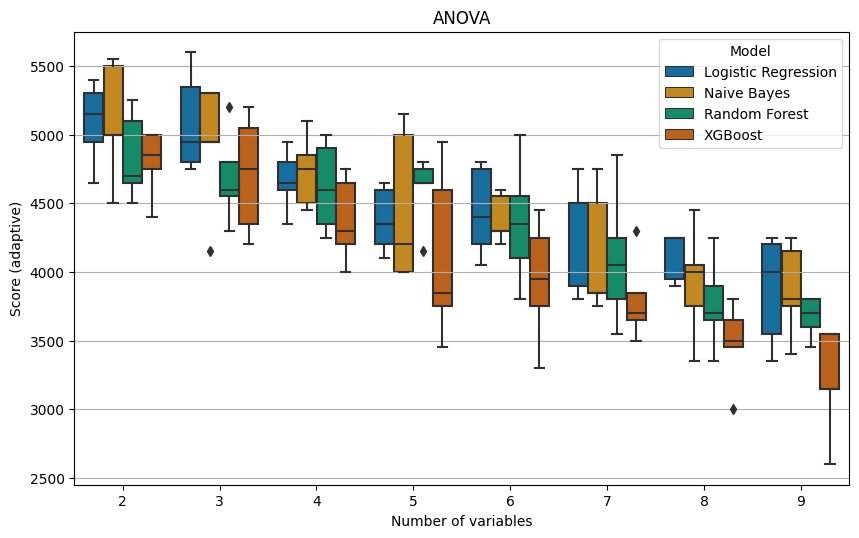

In [32]:
visualise_results(
    results_anova, 
    title='ANOVA',
    score='adaptive',
    save_name='1_anova',
)

## 2. Correlation + ANOVA

In [27]:
def selection_strategy_corr_anova(n_vars_values, x, y, model):
    vars_for_each_n = []

    vars_nocorr = select_vars_correlation(x, y)
    
    for n in n_vars_values:
        selected_vars = select_vars_anova(x[vars_nocorr], y, n)
        vars_for_each_n.append(selected_vars)

    return vars_for_each_n

In [ ]:
results_corr_anova = run_experiment(
    models={
        'Logistic Regression': LogisticRegression(random_state=28),
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_corr_anova,
    n_vars_values=[2, 3, 4, 5, 6, 7, 8, 9]
)
results_corr_anova.to_csv('results/2_corr_anova.csv')

In [33]:
results_corr_anova = pd.read_csv('results/2_corr_anova.csv')

Score in € (adaptive)

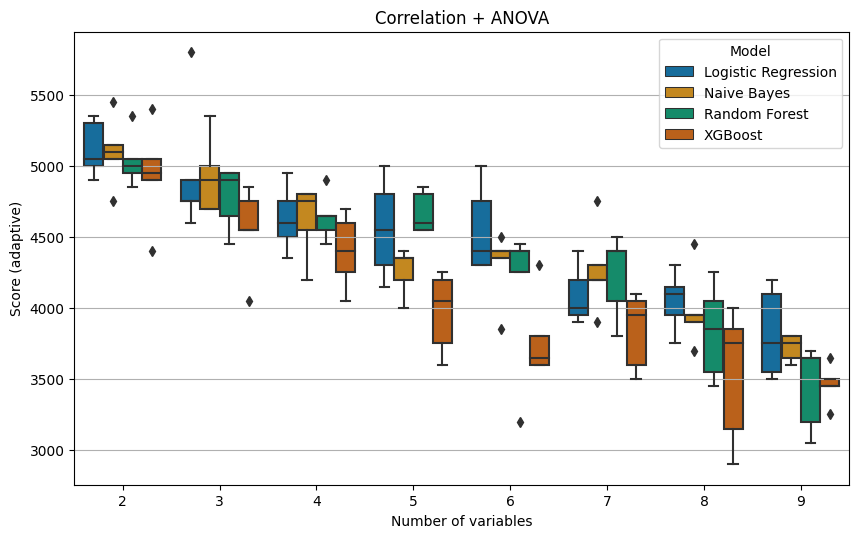

In [34]:
visualise_results(
    results_corr_anova,
    title='Correlation + ANOVA',
    score='adaptive',
    save_name='2_corr_anova',
)

## 3. Correlation + ANOVA + Forward Selection

Steps:
1. Remove highly correlated variables
2. Select top 15 variables using ANOVA
3. Select the best variables using forward selection

In [28]:
def selection_strategy_corr_anova_forward(n_vars_values, x, y, model):
    vars_for_each_n = []

    # step 1
    vars_nocorr = select_vars_correlation(x, y)
    # step 2
    vars_anova = select_vars_anova(x[vars_nocorr], y, top_n=15)
    # step 3
    vars_for_largest_n = forward_selection(
        x[vars_anova], y, model, np.max(n_vars_values), calculate_score_adaptive
    )
    
    for n in n_vars_values:
        vars_for_each_n.append(vars_for_largest_n[:n])

    return vars_for_each_n

In [ ]:
results_corr_anova_forward = run_experiment(
    models={
        'Logistic Regression': LogisticRegression(random_state=28),
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_corr_anova_forward,
    n_vars_values=[2, 3, 4, 5, 6]
)
results_corr_anova_forward.to_csv('results/3_corr_anova_forward.csv')

In [35]:
results_corr_anova_forward = pd.read_csv('results/3_corr_anova_forward.csv')

Score in € (adaptive)

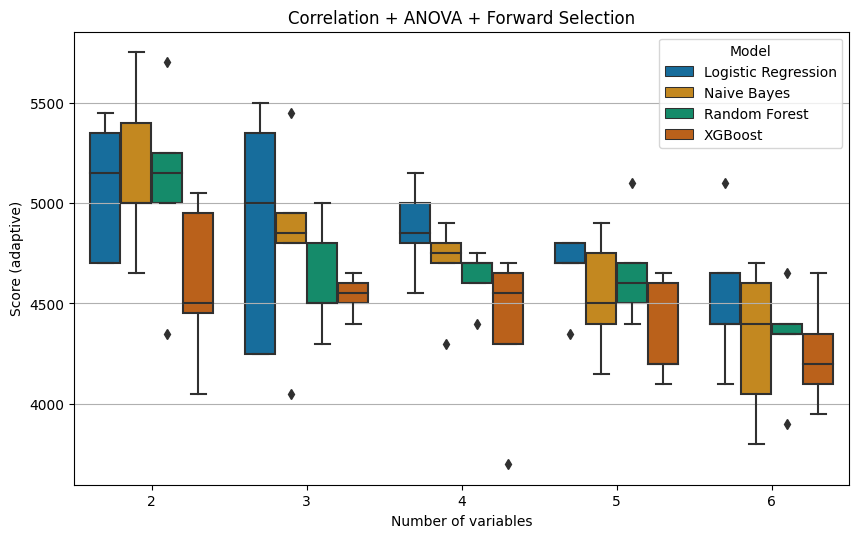

In [36]:
visualise_results(
    results_corr_anova_forward, 
    title='Correlation + ANOVA + Forward Selection',
    save_name='3_corr_anova_forward',
)

## 4. Correlation + ANOVA + Backward Elimination

Steps:
1. Remove highly correlated variables
2. Select top 15 variables using ANOVA
3. Select the best variables using backward elimination

In [29]:
def selection_strategy_corr_anova_backward(n_vars_values, x, y, model):
    vars_for_each_n = []

    # step 1
    vars_nocorr = select_vars_correlation(x, y)
    # step 2
    vars_anova = select_vars_anova(x[vars_nocorr], y, top_n=15)
    # step 3
    vars_for_largest_n = backward_elimination(
        x[vars_anova], y, model, np.max(n_vars_values)
    )
    
    for n in n_vars_values:
        vars_for_each_n.append(vars_for_largest_n[:n])

    return vars_for_each_n

In [ ]:
results_corr_anova_backward = run_experiment(
    models={
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_corr_anova_backward,
    n_vars_values=[2, 3, 4, 5, 6]
)
results_corr_anova_backward.to_csv('results/4_corr_anova_backward.csv')

In [37]:
results_corr_anova_backward = pd.read_csv('results/4_corr_anova_backward.csv')

Score in € (adaptive)

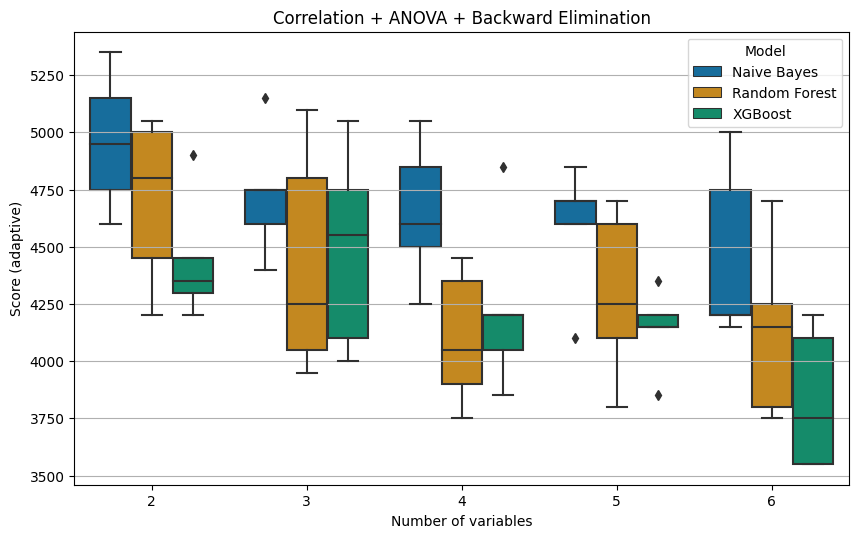

In [38]:
visualise_results(
    results_corr_anova_backward, 
    title='Correlation + ANOVA + Backward Elimination',
    save_name='4_corr_anova_backward',
)

## 5. Permutation VI

In [30]:
def selection_strategy_permutation(n_vars_values, x, y, model):
    vars_for_each_n = []

    vars_for_largest_n = select_vars_permutation(
        x, y, model, top_n=np.max(n_vars_values), random_state=3)
    
    for n in n_vars_values:
        vars_for_each_n.append(vars_for_largest_n[:n])

    return vars_for_each_n

In [42]:
results_permutation = run_experiment(
    models={
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_permutation,
    n_vars_values=[2, 3, 4, 5, 6, 7, 8, 9]
)
results_permutation.to_csv('results/5_permutation.csv')

In [39]:
results_permutation = pd.read_csv('results/5_permutation.csv')

Score in € (adaptive)

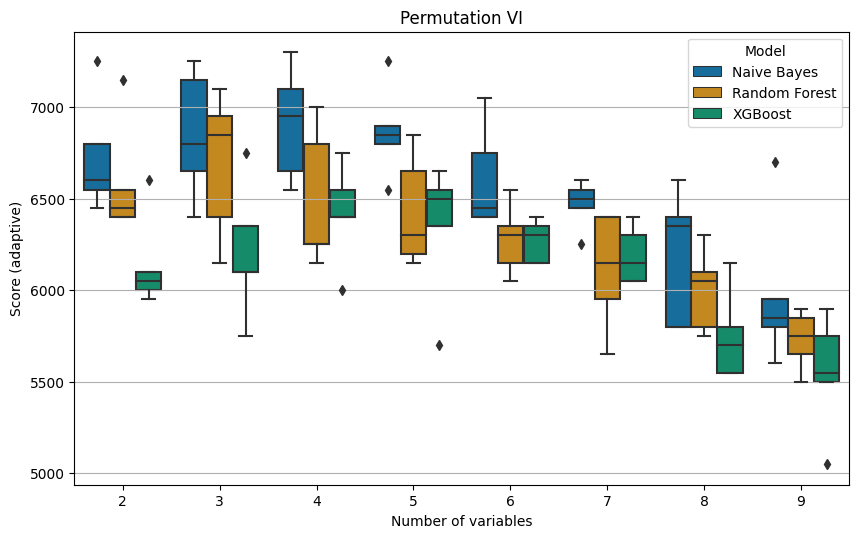

In [40]:
visualise_results(
    results_permutation, 
    title='Permutation VI',
    score='adaptive',
    save_name='5_permutation',
)

## 6. Correlation + Permutation VI

In [31]:
def selection_strategy_corr_permutation(n_vars_values, x, y, model):
    vars_for_each_n = []

    vars_nocorr = select_vars_correlation(x, y)
    vars_for_largest_n = select_vars_permutation(
        x[vars_nocorr], y, model, top_n=np.max(n_vars_values), random_state=3)
    
    for n in n_vars_values:
        vars_for_each_n.append(vars_for_largest_n[:n])

    return vars_for_each_n

In [ ]:
results_corr_permutation = run_experiment(
    models={
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_corr_permutation,
    n_vars_values=[2, 3, 4, 5, 6, 7, 8, 9]
)
results_corr_permutation.to_csv('results/6_corr_permutation.csv')

In [41]:
results_corr_permutation = pd.read_csv('results/6_corr_permutation.csv')

Score in € (adaptive)

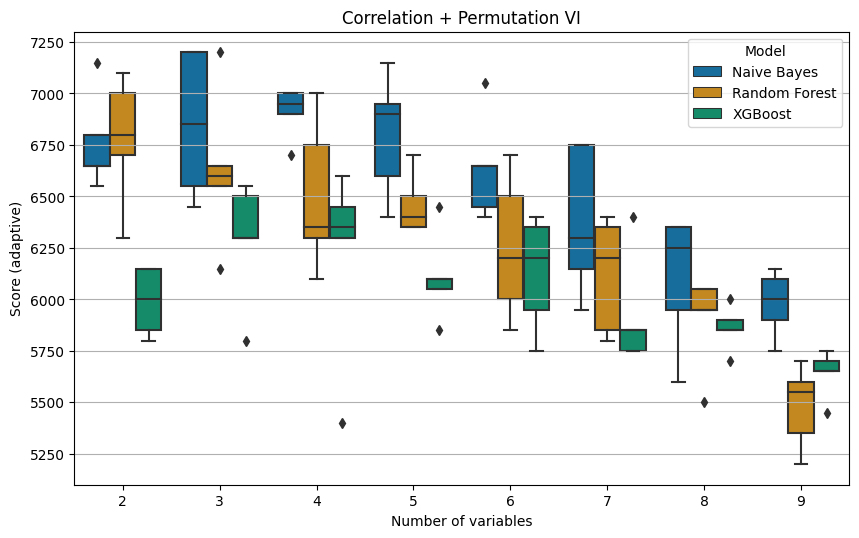

In [42]:
visualise_results(
    results_corr_permutation, 
    title='Correlation + Permutation VI',
    score='adaptive',
    save_name='6_corr_permutation',
)

## 7. Correlation + Permutation VI + Forward Selection

Steps:
1. Remove highly correlated variables
2. Select top 15 variables using Permutation VI
3. Select the best variables using forward selection

In [32]:
def selection_strategy_corr_permutation_forward(n_vars_values, x, y, model):
    vars_for_each_n = []

    # step 1
    vars_nocorr = select_vars_correlation(x, y)
    # step 2
    vars_rfvi = select_vars_permutation(
        x[vars_nocorr], y, model, top_n=15, random_state=3)
    # step 3
    vars_for_largest_n = forward_selection(
        x[vars_rfvi], y, model, np.max(n_vars_values), calculate_score_adaptive
    )
    
    for n in n_vars_values:
        vars_for_each_n.append(vars_for_largest_n[:n])

    return vars_for_each_n

In [ ]:
results_corr_permutation_forward = run_experiment(
    models={
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_corr_permutation_forward,
    n_vars_values=[2, 3, 4, 5, 6, 7, 8]
)
results_corr_permutation_forward.to_csv('results/7_corr_permutation_forward.csv')

In [43]:
results_corr_permutation_forward = pd.read_csv('results/7_corr_permutation_forward.csv')

Score in € (adaptive)

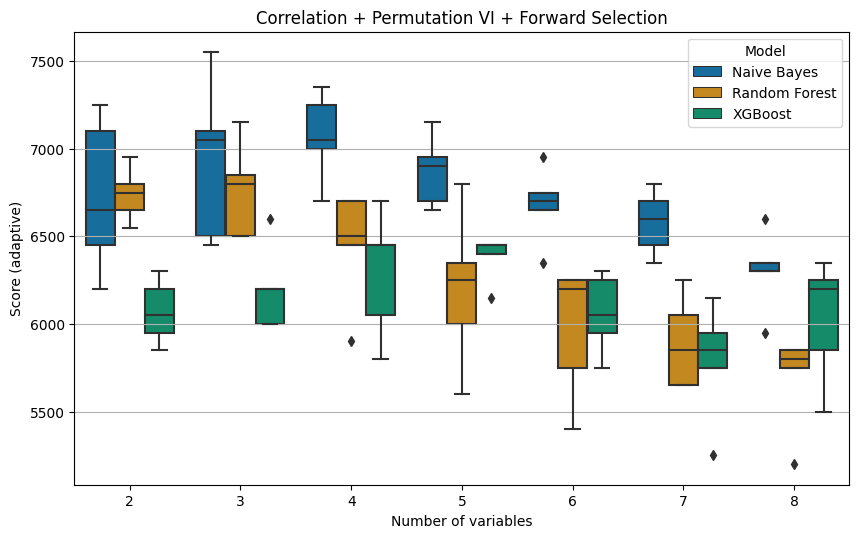

In [44]:
visualise_results(
    results_corr_permutation_forward, 
    title='Correlation + Permutation VI + Forward Selection',
    save_name='7_corr_permutation_forward',
)

## 8. Correlation + Permutation VI + Backward Elimination

Steps:
1. Remove highly correlated variables
2. Select top 15 variables using Permutation VI
3. Select the best variables using backward elimination

In [33]:
def selection_strategy_corr_permutation_backward(n_vars_values, x, y, model):
    vars_for_each_n = []

    # step 1
    vars_nocorr = select_vars_correlation(x, y)
    # step 2
    vars_rfvi = select_vars_permutation(
        x[vars_nocorr], y, model, top_n=15, random_state=3)
    # step 3
    vars_for_largest_n = backward_elimination(
        x[vars_rfvi], y, model, np.max(n_vars_values)
    )
    
    for n in n_vars_values:
        vars_for_each_n.append(vars_for_largest_n[:n])

    return vars_for_each_n

In [ ]:
results_corr_permutation_backward = run_experiment(
    models={
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(random_state=24, max_depth=7),
        'XGBoost': XGBClassifier(random_state=26),
    },
    selection_strategy=selection_strategy_corr_permutation_backward,
    n_vars_values=[2, 3, 4, 5, 6, 7, 8]
)
results_corr_permutation_backward.to_csv('results/8_corr_permutation_backward.csv')

In [45]:
results_corr_permutation_backward = pd.read_csv('results/8_corr_permutation_backward.csv')

Score in € (adaptive)

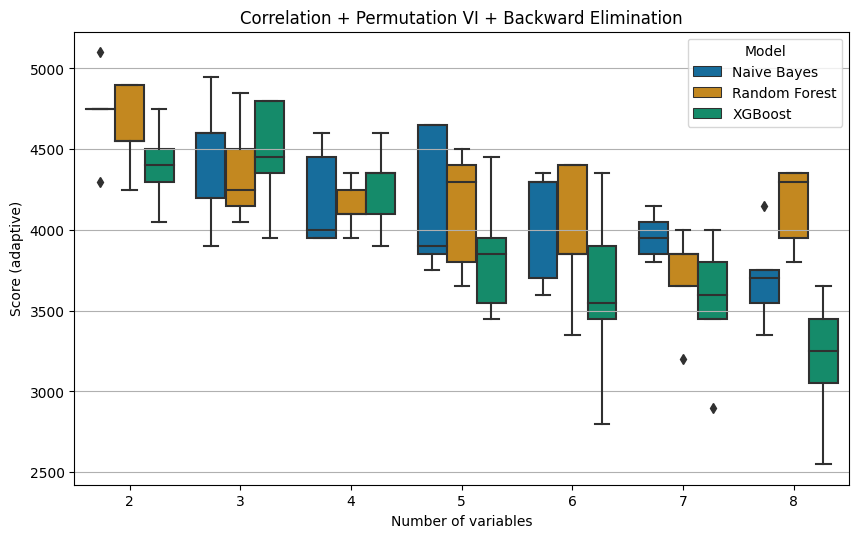

In [46]:
visualise_results(
    results_corr_permutation_backward, 
    title='Correlation + Permutation VI + Backward Elimination',
    save_name='8_corr_permutation_backward',
)

### Choosing the best strategies for each model

In [47]:
result_files = os.listdir('results')

results_full = pd.DataFrame(columns=['Model', 'Number of variables', 'Score', 'Strategy'])

for file_name in result_files:
    file = pd.read_csv('results/'+file_name)[['Model', 'Number of variables', 'Score (adaptive)']]
    file.columns = ['Model','Number of variables','Score']
    file['Strategy'] = file_name
    results_full = pd.concat([file, results_full])

# average scores across CV splits
results_full = results_full\
    .groupby(['Model', 'Number of variables', 'Strategy'])\
    .mean()\
    .reset_index()

In [48]:
results_full

,Model,Number of variables,Strategy,Score
0,Logistic Regression,2,1_anova.csv,5090.0
1,Logistic Regression,2,2_corr_anova.csv,5120.0
2,Logistic Regression,2,3_corr_anova_forward.csv,5070.0
3,Logistic Regression,3,1_anova.csv,5090.0
4,Logistic Regression,3,2_corr_anova.csv,4960.0
...,...,...,...,...
184,XGBoost,8,8_corr_permutation_backward.csv,3190.0
185,XGBoost,9,1_anova.csv,3200.0
186,XGBoost,9,2_corr_anova.csv,3460.0
187,XGBoost,9,5_permutation.csv,5550.0


In [54]:
def show_results_for_model(model_name: str, save_name: Optional[str] = None):

    results_model = results_full[results_full['Model'] == model_name]
    strategies_ids = results_model['Strategy'].map(lambda s: s[0])

    plt.figure(figsize=(8, 6))
    sns.boxplot(results_model, x=strategies_ids, y='Score')
    plt.xlabel('Strategy ID')
    plt.grid(axis='y')

    if save_name is not None:
        plt.savefig(f'plots/{save_name}.png')
    plt.show()

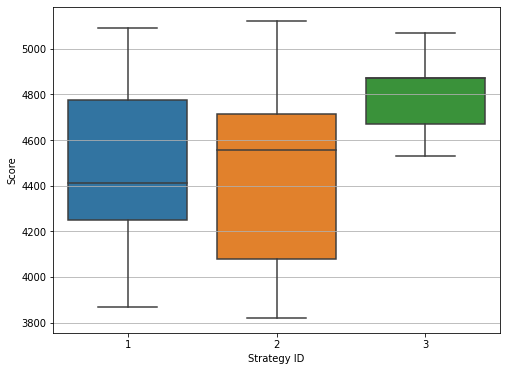

In [55]:
show_results_for_model('Logistic Regression', save_name='strategies_lr')

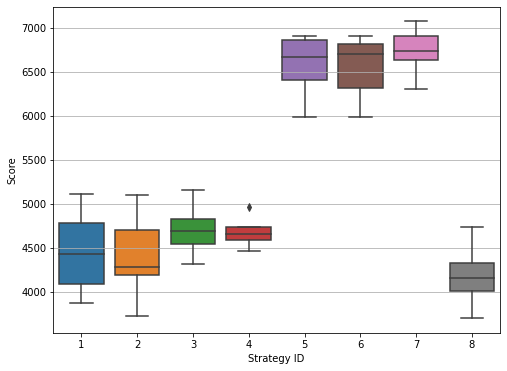

In [56]:
show_results_for_model('Naive Bayes', save_name='strategies_nb')

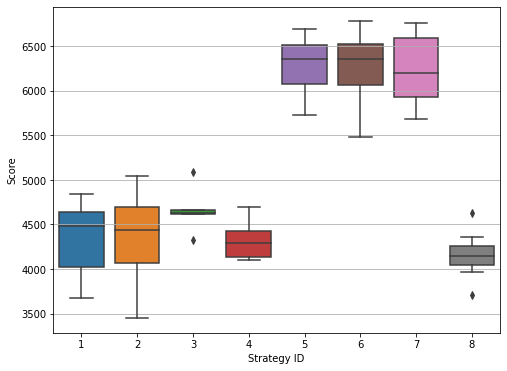

In [57]:
show_results_for_model('Random Forest', save_name='strategies_rf')

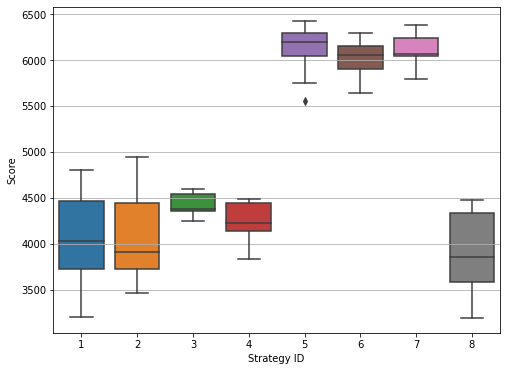

In [58]:
show_results_for_model('XGBoost', save_name='strategies_xgb')

## Bayesian Optimization for best models

In [31]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

### Logistic Regresion + Correlation + ANOVA

In [27]:
X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_LR(n, C):
    n = int(n)
    vars_nocorr = select_vars_correlation(X_train, Y_train)
    selected_vars = select_vars_anova(X_train[vars_nocorr], Y_train, n)
    model = LogisticRegression(random_state=28, C=C)
    score_adaptive = train_cv(model, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (1, 10),  
    'C': (0.0000000001, 100)
}
optimizer = BayesianOptimization(
    f=objective_function_LR,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=10,
    n_iter=100

)

best_hyperparams_lr = optimizer.max['params']
accuracy_lr = optimizer.max['target']

|   iter    |  target   |     C     |     n     |
-------------------------------------------------
| 1         | 3.82e+03  | 37.45     | 9.556     |
| 2         | 4.44e+03  | 73.2      | 6.388     |
| 3         | 5.14e+03  | 15.6      | 2.404     |
| 4         | 4.12e+03  | 5.808     | 8.796     |
| 5         | 4.34e+03  | 60.11     | 7.373     |
| 6         | 3.82e+03  | 2.058     | 9.729     |
| 7         | 5.14e+03  | 83.24     | 2.911     |
| 8         | 5.14e+03  | 18.18     | 2.651     |
| 9         | 4.56e+03  | 30.42     | 5.723     |
| 10        | 4.98e+03  | 43.19     | 3.621     |
| 11        | 5e+03     | 88.97     | 1.0       |
| 12        | 3.82e+03  | 87.21     | 9.162     |
| 13        | 4.34e+03  | 16.73     | 7.137     |
| 14        | 5e+03     | 80.17     | 1.0       |
| 15        | 5e+03     | 47.53     | 1.0       |
| 16        | 5e+03     | 23.41     | 1.059     |
| 17        | 4.35e+03  | 49.05     | 7.101     |
| 18        | 5e+03     | 96.62     | 1.0       |


In [28]:
print(f'best_hyperparams_lr : {best_hyperparams_lr}, accuracy_lr : {accuracy_lr}')

best_hyperparams_lr : {'C': 15.60186404432805, 'n': 2.403950683025824}, accuracy_lr : 5140.0


### Logistic Regresion + Correlation + ANOVA + Forward

In [38]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_LR(n, C):
    n = int(n)
    vars_nocorr = select_vars_correlation(X_train, Y_train)
    selected_vars = select_vars_anova(X_train[vars_nocorr], Y_train, 15)

    model_forward = LogisticRegression(random_state=28, C=C)
    vars_for_n = forward_selection(
        X_train[selected_vars], Y_train, model_forward, n, calculate_score_adaptive
    )

    model = LogisticRegression(random_state=28, C=C)
    score_adaptive = train_cv(model, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (1, 10),  
    'C': (0.0000000001, 100)
}
optimizer = BayesianOptimization(
    f=objective_function_LR,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=20

)

best_hyperparams_lr_2 = optimizer.max['params']
accuracy_lr_2 = optimizer.max['target']

|   iter    |  target   |     C     |     n     |
-------------------------------------------------
| 1         | 2.91e+03  | 37.45     | 9.556     |
| 2         | 2.89e+03  | 73.2      | 6.388     |
| 3         | 2.9e+03   | 15.6      | 2.404     |
| 4         | 2.9e+03   | 5.808     | 8.796     |
| 5         | 2.9e+03   | 44.03     | 1.0       |
| 6         | 2.9e+03   | 36.48     | 9.844     |
| 7         | 2.91e+03  | 10.14     | 5.695     |
| 8         | 2.89e+03  | 0.5644    | 5.174     |
| 9         | 2.91e+03  | 66.75     | 6.78      |
| 10        | 2.9e+03   | 3.247     | 2.937     |
| 11        | 2.91e+03  | 44.18     | 8.419     |
| 12        | 2.89e+03  | 1.862     | 4.945     |
| 13        | 2.89e+03  | 38.74     | 9.185     |
| 14        | 2.89e+03  | 66.63     | 6.792     |
| 15        | 2.9e+03   | 60.41     | 2.365     |
| 16        | 2.9e+03   | 79.28     | 8.955     |
| 17        | 2.92e+03  | 41.94     | 2.489     |
| 18        | 2.91e+03  | 11.5      | 2.786     |


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 9/9 [00:08<00:00,  1.12it/s]
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

In [39]:
print(f'best_hyperparams_lr_2 : {best_hyperparams_lr_2}, accuracy_lr_2 : {accuracy_lr_2}')

best_hyperparams_lr_2 : {'C': 41.94048279276871, 'n': 2.4889779400115497}, accuracy_lr_2 : 2920.0


### Naive Bayes + correlation + permutation

In [32]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_NB(n, var_smoothing):
    
    n = int(n)
    model_permutation = GaussianNB(var_smoothing=var_smoothing)
    vars_nocorr = select_vars_correlation(X_train, Y_train)
    selected_vars = select_vars_permutation(
        X_train[vars_nocorr], Y_train, model_permutation, top_n=n, random_state=3)
    
    model = GaussianNB(var_smoothing=var_smoothing)
    score_adaptive = train_cv(model, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (1, 10),  
    'var_smoothing': (1e-12, 1e-8) 
}
optimizer = BayesianOptimization(
    f=objective_function_NB,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=20

)

best_hyperparams_nb = optimizer.max['params']
accuracy_nb = optimizer.max['target']

|   iter    |  target   |     n     | var_sm... |
-------------------------------------------------
| 1         | 6.84e+03  | 4.371     | 9.507e-09 |
| 2         | 6.35e+03  | 7.588     | 5.987e-09 |
| 3         | 6.78e+03  | 2.404     | 1.561e-09 |
| 4         | 6.46e+03  | 1.523     | 8.662e-09 |
| 5         | 6.35e+03  | 7.057     | 5.309e-09 |
| 6         | 6.89e+03  | 3.414     | 6.386e-09 |
| 7         | 5.81e+03  | 10.0      | 1e-12     |
| 8         | 6.89e+03  | 3.861     | 4.743e-09 |
| 9         | 6.89e+03  | 3.021     | 7.851e-09 |
| 10        | 6.89e+03  | 3.663     | 1e-12     |
| 11        | 6.89e+03  | 3.188     | 6.168e-09 |
| 12        | 6.89e+03  | 3.772     | 1e-08     |
| 13        | 6.89e+03  | 3.534     | 1e-08     |
| 14        | 6.89e+03  | 3.096     | 7.323e-09 |
| 15        | 6.89e+03  | 3.305     | 9.596e-09 |
| 16        | 6.89e+03  | 3.956     | 1e-08     |
| 17        | 6.89e+03  | 3.897     | 1e-08     |
| 18        | 6.78e+03  | 2.955     | 3.251e-09 |


In [33]:
print(f'best_hyperparams_nb : {best_hyperparams_nb}, accuracy_nb : {accuracy_nb}')

best_hyperparams_nb : {'n': 3.4141716366341797, 'var_smoothing': 6.3863282502212275e-09}, accuracy_nb : 6890.0


### Naive Bayes + correlation + permutation + forward selection

In [52]:
X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_NB_2(n, var_smoothing):
    
    n = int(n)
    model_permutation = GaussianNB(var_smoothing=var_smoothing)
    vars_nocorr = select_vars_correlation(X_train, Y_train)
    selected_vars_permutation = select_vars_permutation(
        X_train[vars_nocorr], Y_train, model_permutation, top_n=n, random_state=3)
    selected_vars = forward_selection(
        X_train[selected_vars_permutation], Y_train, model_permutation, n, calculate_score_adaptive)

    
    model = GaussianNB(var_smoothing=var_smoothing)
    score_adaptive = train_cv(model, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (2, 8),  
    'var_smoothing': (1e-12, 1e-8) 
}
optimizer = BayesianOptimization(
    f=objective_function_NB_2,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=20

)

best_hyperparams_nb_2 = optimizer.max['params']
accuracy_nb_2 = optimizer.max['target']

|   iter    |  target   |     n     | var_sm... |
-------------------------------------------------
| 1         | 6.84e+03  | 4.247     | 9.507e-09 |
| 2         | 6.55e+03  | 6.392     | 5.987e-09 |
| 3         | 6.78e+03  | 2.936     | 1.561e-09 |
| 4         | 6.78e+03  | 2.349     | 8.662e-09 |
| 5         | 6.13e+03  | 8.0       | 3.277e-09 |
| 6         | 6.82e+03  | 5.03      | 4.253e-09 |
| 7         | 6.84e+03  | 4.579     | 1e-08     |
| 8         | 6.84e+03  | 4.407     | 6.01e-09  |
| 9         | 6.89e+03  | 3.83      | 1e-08     |
| 10        | 6.89e+03  | 3.517     | 1e-12     |
| 11        | 6.78e+03  | 2.0       | 2.994e-09 |
| 12        | 6.89e+03  | 3.67      | 1e-08     |
| 13        | 6.82e+03  | 5.583     | 1e-08     |
| 14        | 6.89e+03  | 3.384     | 6.705e-09 |
| 15        | 6.89e+03  | 3.759     | 8.354e-09 |
| 16        | 6.89e+03  | 3.441     | 1e-08     |
| 17        | 6.89e+03  | 3.594     | 1e-12     |
| 18        | 6.89e+03  | 3.894     | 3.23e-09  |


100%|██████████| 3/3 [00:00<00:00, 17.08it/s]


In [53]:
print(f'best_hyperparams_nb : {best_hyperparams_nb_2}, accuracy_nb_2 : {accuracy_nb_2}')

best_hyperparams_nb : {'n': 3.8299234636966686, 'var_smoothing': 1e-08}, accuracy_nb_2 : 6890.0


### Random Forest + correlation + permutation

In [34]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier

X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_RF(n, n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    n = int(n)
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    vars_nocorr = select_vars_correlation(X_train, Y_train)
    selected_vars = select_vars_permutation(
        X_train[vars_nocorr], Y_train, model, top_n=n, random_state=3)

    score_adaptive = train_cv(model, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (2, 8),
    'n_estimators': (1, 200),  
    'max_depth': (5, 40),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

optimizer = BayesianOptimization(
    f=objective_function_RF,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=20
)

best_hyperparams_rf = optimizer.max['params']
accuracy_rf = optimizer.max['target']

|   iter    |  target   | max_depth | min_sa... | min_sa... |     n     | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 6.3e+03   | 18.11     | 9.556     | 15.18     | 5.592     | 32.05     |
| 2         | 6.24e+03  | 10.46     | 1.523     | 17.59     | 5.607     | 141.9     |
| 3         | 6.42e+03  | 5.72      | 9.729     | 16.98     | 3.274     | 37.18     |
| 4         | 6.48e+03  | 11.42     | 3.738     | 11.45     | 4.592     | 58.95     |
| 5         | 6.01e+03  | 18.55     | 7.22      | 6.645     | 6.992     | 122.4     |
| 6         | 6.5e+03   | 10.92     | 5.336     | 10.98     | 4.833     | 58.3      |
| 7         | 5.8e+03   | 5.0       | 10.0      | 2.0       | 8.0       | 71.89     |
| 8         | 6.58e+03  | 12.4      | 8.104     | 19.0      | 2.0       | 50.78     |
| 9         | 6.35e+03  | 27.11     | 10.0      | 11.75     | 2.0       | 53.68     |
| 10        | 6.4e+03   | 8.499     | 1.083     | 6.84

In [35]:
print(f'best_hyperparams_rf : {best_hyperparams_rf}, accuracy_rf : {accuracy_rf}')

best_hyperparams_rf : {'max_depth': 5.428314747226141, 'min_samples_leaf': 3.9396751403403734, 'min_samples_split': 7.736338347630299, 'n': 3.2552774252258088, 'n_estimators': 57.251577465650364}, accuracy_rf : 6610.0


In [40]:
X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_RF(n, n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    n = int(n)
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    vars_nocorr = select_vars_correlation(X_train, Y_train)
    selected_vars = select_vars_permutation(
        X_train[vars_nocorr], Y_train, model, top_n=n, random_state=3)

    score_adaptive = train_cv(model_permutation, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (2, 8),
    'n_estimators': (1, 200),  
    'max_depth': (5, 40),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

optimizer = BayesianOptimization(
    f=objective_function_RF,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=20
)

best_hyperparams_rf_cv = optimizer.max['params']
accuracy_rf_cv = optimizer.max['target']

|   iter    |  target   | max_depth | min_sa... | min_sa... |     n     | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 6.67e+03  | 18.11     | 9.556     | 15.18     | 5.592     | 32.05     |
| 2         | 6.67e+03  | 10.46     | 1.523     | 17.59     | 5.607     | 141.9     |
| 3         | 6.86e+03  | 5.72      | 9.729     | 16.98     | 3.274     | 37.18     |
| 4         | 6.8e+03   | 11.42     | 3.738     | 11.45     | 4.592     | 58.95     |
| 5         | 6.31e+03  | 18.55     | 7.22      | 6.645     | 6.992     | 122.4     |
| 6         | 6.81e+03  | 10.92     | 5.336     | 10.98     | 4.833     | 58.3      |
| 7         | 6.89e+03  | 5.0       | 1.0       | 20.0      | 3.038     | 178.1     |
| 8         | 4.33e+03  | 26.65     | 1.0       | 20.0      | 8.0       | 193.6     |
| 9         | 6.8e+03   | 5.011     | 1.562     | 2.193     | 4.924     | 161.7     |
| 10        | 5.45e+03  | 6.472     | 1.702     | 2.70

In [41]:
print(f'best_hyperparams_rf_cv : {best_hyperparams_rf_cv}, accuracy_rf_cv : {accuracy_rf_cv}')

best_hyperparams_rf_cv : {'max_depth': 5.0, 'min_samples_leaf': 1.0, 'min_samples_split': 20.0, 'n': 3.037651383360064, 'n_estimators': 178.14560292256616}, accuracy_rf_cv : 6890.0


### Random Forest + permutation

In [36]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier

X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_RF_2(n, n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    n = int(n)
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    selected_vars = select_vars_permutation(
        X_train, Y_train, model, top_n=n, random_state=3)
    score_adaptive = train_cv(model, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (2, 8),
    'n_estimators': (1, 200),  
    'max_depth': (5, 40),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}
optimizer = BayesianOptimization(
    f=objective_function_RF_2,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=20
)

best_hyperparams_rf_2 = optimizer.max['params']
accuracy_rf_2 = optimizer.max['target']

|   iter    |  target   | max_depth | min_sa... | min_sa... |     n     | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 6.36e+03  | 18.11     | 9.556     | 15.18     | 5.592     | 32.05     |
| 2         | 6.24e+03  | 10.46     | 1.523     | 17.59     | 5.607     | 141.9     |
| 3         | 6.74e+03  | 5.72      | 9.729     | 16.98     | 3.274     | 37.18     |
| 4         | 6.23e+03  | 11.42     | 3.738     | 11.45     | 4.592     | 58.95     |
| 5         | 6.01e+03  | 18.55     | 7.22      | 6.645     | 6.992     | 122.4     |
| 6         | 6.61e+03  | 7.519     | 7.839     | 19.63     | 3.914     | 35.15     |
| 7         | 6.71e+03  | 5.085     | 4.504     | 9.901     | 3.077     | 35.11     |
| 8         | 6.6e+03   | 5.0       | 10.0      | 2.0       | 2.0       | 22.84     |
| 9         | 5.65e+03  | 5.0       | 1.0       | 2.0       | 2.0       | 1.0       |
| 10        | 5.04e+03  | 40.0      | 1.0       | 20.0

In [37]:
print(f'best_hyperparams_rf_2 : {best_hyperparams_rf_2}, accuracy_rf_2 : {accuracy_rf_2}')

best_hyperparams_rf_2 : {'max_depth': 5.0, 'min_samples_leaf': 10.0, 'min_samples_split': 20.0, 'n': 2.0, 'n_estimators': 92.49303810184936}, accuracy_rf_2 : 6760.0


### XGBoost + correlation + permutation

In [30]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier

X_train = x_train.copy()
Y_train = y_train.copy()

def objective_function_xgb(n, n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma):
    n = int(n)  # Conversion to int because n is a Bayesian optimization parameter 

    model = XGBClassifier(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=26
    )

    vars_nocorr = select_vars_correlation(X_train, Y_train)
    selected_vars = select_vars_permutation(
        X_train[vars_nocorr], Y_train, model, top_n=n, random_state=3)
    
    score_adaptive = train_cv(model, X_train[selected_vars], Y_train, 5, calculate_score_adaptive)
    return score_adaptive

pbounds = {
    'n': (2, 8),
    'n_estimators': (1, 200),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 40),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'gamma': (0, 5)
}
optimizer = BayesianOptimization(
    f=objective_function_xgb,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=4,
    n_iter=20
)

best_hyperparams_xgb = optimizer.max['params']
accuracy_xgb = optimizer.max['target']

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... |     n     | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 6.42e+03  | 0.6873    | 4.754     | 0.2223    | 25.15     | 2.404     | 2.936     | 12.56     | 0.9331    |
| 2         | 6.75e+03  | 0.8006    | 3.54      | 0.01597   | 38.89     | 8.492     | 3.274     | 37.18     | 0.5917    |
| 3         | 6.48e+03  | 0.6521    | 2.624     | 0.1353    | 13.78     | 6.507     | 2.837     | 59.14     | 0.6832    |
| 4         | 6.37e+03  | 0.728     | 3.926     | 0.06791   | 22.03     | 6.332     | 2.279     | 121.9     | 0.5853    |
| 5         | 6.63e+03  | 0.5622    | 4.328     | 0.2973    | 39.63     | 8.17      | 4.793     | 36.42     | 0.8041    |
| 6         | 6.84e+03  | 1.0       | 2.833     | 0.01      | 39.32     | 9.991     | 2.0       | 38.98     | 0.5       |
| 7         | 6.82e+03  

In [31]:
print(f'best_hyperparams_xgb : {best_hyperparams_xgb}, accuracy_xgb : {accuracy_xgb}')

best_hyperparams_xgb : {'colsample_bytree': 1.0, 'gamma': 2.8329221224953938, 'learning_rate': 0.01, 'max_depth': 39.315165724517115, 'min_child_weight': 9.99093137540363, 'n': 2.0, 'n_estimators': 38.983454128723125, 'subsample': 0.5}, accuracy_xgb : 6840.0


## Investigation of final models

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from statistics import mean

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='weighted')

def recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average='weighted')

def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

### Naive Bayes + correlation + permutation + forward selection

In [53]:
X_train = x_train.copy()
Y_train = y_train.copy()

vars_nocorr = select_vars_correlation(X_train, Y_train)
model_permutation = GaussianNB(var_smoothing=1e-08)

selected_vars_permutation = select_vars_permutation(
    X_train[vars_nocorr], Y_train, model_permutation, top_n=15, random_state=42)

CORR_PERMUTATION_NB = forward_selection(
        X_train[selected_vars_permutation], Y_train, model_permutation, 3, calculate_score_adaptive)


accuracies_nb = [] 
precisions_nb = []
recalls_nb = []
f1s_nb = []
scores_nb = []

for i in range(100):
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train[CORR_PERMUTATION_NB], Y_train, test_size=0.2, random_state=i, stratify=y_train)

    final_model = GaussianNB(var_smoothing=1e-08)
    final_model.fit(X_train_split, Y_train_split)
    y_pred = final_model.predict(X_test_split)

    accuracy_nb = accuracy_score(Y_test_split, y_pred)
    precision_nb = precision_score(Y_test_split, y_pred, average='weighted')
    recall_nb = recall_score(Y_test_split, y_pred, average='weighted')
    f1_nb = f1_score(Y_test_split, y_pred, average='weighted')
    conf_matrix_nb = confusion_matrix(Y_test_split, y_pred)

    y_pred = final_model.predict_proba(X_test_split)
    score_nb = calculate_score_adaptive(Y_test_split, y_pred, len(CORR_PERMUTATION_NB))

    accuracies_nb.append(accuracy_nb)
    precisions_nb.append(precision_nb)
    recalls_nb.append(recall_nb)
    f1s_nb.append(f1_nb)
    scores_nb.append(score_nb)

accuracy_avg_nb = mean(accuracies_nb)
precision_avg_nb = mean(precisions_nb)
recall_avg_nb = mean(recalls_nb)
f1_avg_nb = mean(f1s_nb)
score_avg_nb = mean(scores_nb)


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


In [54]:
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Score'],
    'Average Value': [accuracy_avg_nb, precision_avg_nb, recall_avg_nb, f1_avg_nb, score_avg_nb]
}

df = pd.DataFrame(data)
print(df)

      Metric  Average Value
0   Accuracy       0.631260
1  Precision       0.635783
2     Recall       0.631260
3   F1 Score       0.628019
4      Score    6887.000000


In [56]:
CORR_PERMUTATION_NB

[102, 105, 101]

### Random Forest + correlation + permutation 

In [45]:
X_train = x_train.copy()
Y_train = y_train.copy() 

vars_nocorr = select_vars_correlation(X_train, Y_train)
model_permutation = RandomForestClassifier(n_estimators=178,
                                   max_depth=5,
                                   min_samples_split=20,
                                   min_samples_leaf=1,
                                   random_state=42)

CORR_PERMUTATION_RF = select_vars_permutation(
    X_train[vars_nocorr], Y_train, model_permutation, top_n=3, random_state=42)

accuracies_rf = []
precisions_rf = []
recalls_rf = []
f1s_rf = []
scores_rf = []

for i in range(100):
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train[CORR_PERMUTATION_RF], Y_train, test_size=0.2, random_state=i, stratify=y_train)

    model_rf = RandomForestClassifier(n_estimators=178,
                                   max_depth=5,
                                   min_samples_split=20,
                                   min_samples_leaf=1,
                                   random_state=42)
    
    model_rf.fit(X_train_split, Y_train_split)
    y_pred = model_rf.predict(X_test_split)

    accuracy_rf = accuracy_score(Y_test_split, y_pred)
    precision_rf = precision_score(Y_test_split, y_pred, average='weighted')
    recall_rf = recall_score(Y_test_split, y_pred, average='weighted')
    f1_rf = f1_score(Y_test_split, y_pred, average='weighted')
    conf_matrix_rf = confusion_matrix(Y_test_split, y_pred)

    y_pred = model_rf.predict_proba(X_test_split)
    score_rf = calculate_score_adaptive(Y_test_split, y_pred, len(CORR_PERMUTATION_RF))

    accuracies_rf.append(accuracy_rf)
    precisions_rf.append(precision_rf)
    recalls_rf.append(recall_rf)
    f1s_rf.append(f1_rf)
    scores_rf.append(score_rf)

accuracy_avg_rf = mean(accuracies_rf)
precision_avg_rf = mean(precisions_rf)
recall_avg_rf = mean(recalls_rf)
f1_avg_rf = mean(f1s_rf)
score_avg_rf = mean(scores_rf)

In [46]:
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Score'],
    'Average Value': [accuracy_avg_rf, precision_avg_rf, recall_avg_rf, f1_avg_rf, score_avg_rf]
}

df = pd.DataFrame(data)
print(df)

      Metric  Average Value
0   Accuracy       0.632270
1  Precision       0.635643
2     Recall       0.632270
3   F1 Score       0.629821
4      Score    6501.000000


In [47]:
CORR_PERMUTATION_RF

[105, 100, 103]

### XGBoost + correlation + permutation

In [48]:
X_train = x_train.copy()
Y_train = y_train.copy()

vars_nocorr = select_vars_correlation(X_train, Y_train)
model_permutation = XGBClassifier(
        n_estimators=int(38),
        learning_rate=0.01,
        max_depth=int(39),
        min_child_weight=9.99093137540363,
        subsample=0.5,
        colsample_bytree=1.0,
        gamma=2.8329221224953938,
        random_state=26
    )

CORR_PERMUTATION_XGB = select_vars_permutation(
    X_train[vars_nocorr], Y_train, model_permutation, top_n=2, random_state=42)

accuracies_xgb = []
precisions_xgb = []
recalls_xgb = []
f1s_xgb = []
scores_xgb = []

for i in range(100):
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train[CORR_PERMUTATION_XGB], Y_train, test_size=0.2, random_state=i, stratify=y_train)

    model_xgb = XGBClassifier(
        n_estimators=int(38),
        learning_rate=0.01,
        max_depth=int(39),
        min_child_weight=9.99093137540363,
        subsample=0.5,
        colsample_bytree=1.0,
        gamma=2.8329221224953938,
        random_state=26
    )
    
    model_xgb.fit(X_train_split, Y_train_split)
    y_pred = model_xgb.predict(X_test_split)

    accuracy_xgb = accuracy_score(Y_test_split, y_pred)
    precision_xgb = precision_score(Y_test_split, y_pred, average='weighted')
    recall_xgb = recall_score(Y_test_split, y_pred, average='weighted')
    f1_xgb = f1_score(Y_test_split, y_pred, average='weighted')
    conf_matrix_xgb = confusion_matrix(Y_test_split, y_pred)

    y_pred = model_xgb.predict_proba(X_test_split)
    score_xgb = calculate_score_adaptive(Y_test_split, y_pred, len(CORR_PERMUTATION_XGB))

    accuracies_xgb.append(accuracy_xgb)
    precisions_xgb.append(precision_xgb)
    recalls_xgb.append(recall_xgb)
    f1s_xgb.append(f1_xgb)
    scores_xgb.append(score_xgb)

accuracy_avg_xgb = mean(accuracies_xgb)
precision_avg_xgb = mean(precisions_xgb)
recall_avg_xgb = mean(recalls_xgb)
f1_avg_xgb = mean(f1s_xgb)
score_avg_xgb = mean(scores_xgb)

In [49]:
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Score'],
    'Average Value': [accuracy_avg_xgb, precision_avg_xgb, recall_avg_xgb, f1_avg_xgb, score_avg_xgb]
}

df = pd.DataFrame(data)
print(df)

      Metric  Average Value
0   Accuracy       0.600240
1  Precision       0.602963
2     Recall       0.600240
3   F1 Score       0.597398
4      Score    6618.000000


In [50]:
CORR_PERMUTATION_XGB

[102, 105]

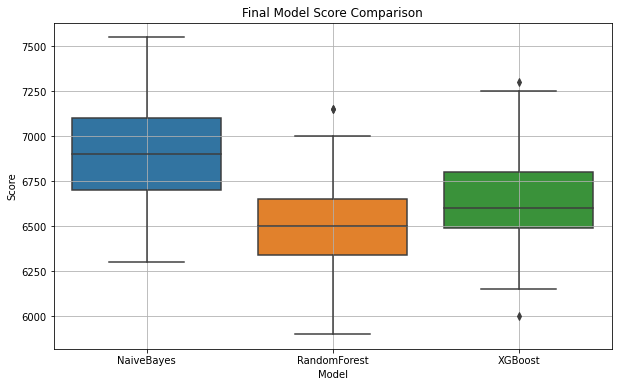

In [59]:
data = {
    'Model': ['NaiveBayes']*len(scores_nb) + ['RandomForest']*len(scores_rf) + ['XGBoost']*len(scores_xgb),
    'Scores': scores_nb + scores_rf + scores_xgb
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Scores', data=df)
plt.title('Final Model Score Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.grid(True)

plt.show()

As we can see, the best results were obtained with the Naive Bayes model. Therefore, we will use this model for the final prediction.

### FINAL PREDICTION

In [27]:
X_train = x_train.copy()
Y_train = y_train.copy()

vars_nocorr = select_vars_correlation(X_train, Y_train)
model_permutation = GaussianNB(var_smoothing=1e-08)

selected_vars_permutation = select_vars_permutation(
    X_train[vars_nocorr], Y_train, model_permutation, top_n=15, random_state=42)

CORR_PERMUTATION_NB = forward_selection(
        X_train[selected_vars_permutation], Y_train, model_permutation, 3, calculate_score_adaptive)


final_model = GaussianNB(var_smoothing=1e-08)
final_model.fit(X_train[CORR_PERMUTATION_NB], Y_train)

y_pred_test = final_model.predict_proba(x_test[CORR_PERMUTATION_NB])
save_solution(y_pred_test, CORR_PERMUTATION_NB)

100%|██████████| 3/3 [00:03<00:00,  1.13s/it]
